In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from tqdm import tqdm

In [2]:
class AudioDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.file_paths = []
        self.labels = []  # Important for stratification
        
        # Map emotion label from filename to emotion category
        self.emotion_map = {
            '01': 0,  # neutral
            '02': 1,  # calm
            '03': 2,  # happy
            '04': 3,  # sad
            '05': 4,  # angry
            '06': 5,  # fearful
            '07': 6,  # disgust
            '08': 7   # surprised
        }
        
        # Search all actor folders 
        actor_dirs = glob.glob(os.path.join(data_path, "Actor_*"))
        
        print(f"Found {len(actor_dirs)} actor directories")
        
        # Process each actor directory
        for actor_dir in actor_dirs:
            # Get all audio files in this actor folder
            audio_files = glob.glob(os.path.join(actor_dir, "*.wav"))
            
            for audio_file in audio_files:
                filename = os.path.basename(audio_file)
                # Extract emotion from filename (3rd part in convention)
                parts = filename.split('-')
                if len(parts) >= 3:
                    emotion_code = parts[2]
                    if emotion_code in self.emotion_map:
                        self.file_paths.append(audio_file)
                        self.labels.append(self.emotion_map[emotion_code])
        
        print(f"Found {len(self.file_paths)} audio files with valid emotions")
        
        # Print emotion distribution
        self.emotion_counts = {}
        for label in self.labels:
            if label not in self.emotion_counts:
                self.emotion_counts[label] = 0
            self.emotion_counts[label] += 1
        
        print("Emotion distribution:")
        for emotion, count in sorted(self.emotion_counts.items()):
            emotion_name = list(self.emotion_map.keys())[list(self.emotion_map.values()).index(emotion)]
            print(f"  - {emotion_name} (class {emotion}): {count} files")
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        audio_path = self.file_paths[idx]
        label = self.labels[idx]
        
        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Apply transformations if any
        if self.transform:
            waveform = self.transform(waveform)
            
        # Create mel spectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )
        mel_spectrogram = mel_transform(waveform)
        
        # Convert to decibels
        mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
        
        # Ensure 3 channels for CNN (repeat the spectrogram 3 times)
        mel_spectrogram = mel_spectrogram.repeat(3, 1, 1)
        
        return mel_spectrogram, label

In [3]:
def pad_collate(batch):
    """
    Pads spectrograms to have the same size before batching.
    """
    # Find the maximum spectrogram width in the batch
    max_width = max([item[0].shape[2] for item in batch])
    
    # List to store padded spectrograms and their labels
    padded_spectrograms = []
    labels = []
    
    for spectrogram, label in batch:
        # Get the current width
        current_width = spectrogram.shape[2]
        
        # Calculate padding needed
        padding_needed = max_width - current_width
        
        if padding_needed > 0:
            # Pad the spectrogram
            padded = torch.nn.functional.pad(spectrogram, (0, padding_needed, 0, 0, 0, 0))
            padded_spectrograms.append(padded)
        else:
            padded_spectrograms.append(spectrogram)
        
        labels.append(label)
    
    # Stack the padded spectrograms and labels
    padded_spectrograms = torch.stack(padded_spectrograms)
    labels = torch.tensor(labels)
    
    return padded_spectrograms, labels

In [5]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Block 1
            nn.Conv2d(64, 64, kernel_size=7, padding=3, groups=64),  # Depthwise
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(128, 128, kernel_size=7, padding=3, groups=128),  # Depthwise
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(256, 256, kernel_size=7, padding=3, groups=256),  # Depthwise
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Global average pooling to 1x1
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Explicitly flatten to ensure proper shape
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # Input is 512 from the last conv layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Add shape printing for debugging
        # print(f"Input shape: {x.shape}")
        x = self.features(x)
        # print(f"After features shape: {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape: {x.shape}")
        return x

In [4]:
def create_stratified_dataloaders(dataset, batch_size=32, train_split=0.80, seed=42):
    """
    Create train and validation dataloaders with stratified sampling based on emotion labels.
    This ensures each emotion class maintains the same train_split:val_split ratio.
    """
    # Get all indices and labels
    indices = list(range(len(dataset)))
    labels = dataset.labels
    
    # Use stratified sampling to split the dataset
    train_indices, val_indices = train_test_split(
        indices, 
        test_size=1-train_split,  # 1 - 0.66 = 0.20 (~20%)
        random_state=seed,
        stratify=labels  # This ensures stratification based on emotion labels
    )
    
    # Create subset datasets
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # Verify stratification
    train_labels = [dataset.labels[i] for i in train_indices]
    val_labels = [dataset.labels[i] for i in val_indices]
    
    # Count emotions in each split
    train_counts = {}
    val_counts = {}
    for label in range(8):  # 8 emotion classes
        train_count = train_labels.count(label)
        val_count = val_labels.count(label)
        train_counts[label] = train_count
        val_counts[label] = val_count
    
    print("\nVerifying stratified split (80:20):")
    print("Emotion | Train | Val | Train% | Target%")
    print("--------|-------|-----|--------|--------")
    
    emotion_names = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
    for i, name in enumerate(emotion_names):
        if i in train_counts and i in val_counts:
            total = train_counts[i] + val_counts[i]
            train_pct = train_counts[i] / total * 100 if total > 0 else 0
            print(f"{name.ljust(8)} | {train_counts[i]:5d} | {val_counts[i]:3d} | {train_pct:6.2f}% | 66.00%")
    
    # Create DataLoaders with custom collate function
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=pad_collate  # Add this line
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        collate_fn=pad_collate  # Add this line
    )
    
    return train_loader, val_loader

Using device: cuda
Found 19 actor directories
Found 1140 audio files with valid emotions
Emotion distribution:
  - 01 (class 0): 76 files
  - 02 (class 1): 152 files
  - 03 (class 2): 152 files
  - 04 (class 3): 152 files
  - 05 (class 4): 152 files
  - 06 (class 5): 152 files
  - 07 (class 6): 152 files
  - 08 (class 7): 152 files

Verifying stratified split (80:20):
Emotion | Train | Val | Train% | Target%
--------|-------|-----|--------|--------
neutral  |    50 |  26 |  65.79% | 66.00%
calm     |   101 |  51 |  66.45% | 66.00%
happy    |   101 |  51 |  66.45% | 66.00%
sad      |   100 |  52 |  65.79% | 66.00%
angry    |   100 |  52 |  65.79% | 66.00%
fearful  |   100 |  52 |  65.79% | 66.00%
disgust  |   100 |  52 |  65.79% | 66.00%
surprised |   100 |  52 |  65.79% | 66.00%


Epoch 1/70 [Val]: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Epoch 1/70:
  Train Loss: 2.0100
  Val Loss: 1.9649, Val Accuracy: 0.2397
  Saved new best model!


Epoch 2/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 2/70:
  Train Loss: 1.7888
  Val Loss: 2.0184, Val Accuracy: 0.2139


Epoch 3/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 3/70:
  Train Loss: 1.6646
  Val Loss: 1.6842, Val Accuracy: 0.3711
  Saved new best model!


Epoch 4/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


Epoch 4/70:
  Train Loss: 1.4917
  Val Loss: 1.9134, Val Accuracy: 0.2990


Epoch 5/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch 5/70:
  Train Loss: 1.4108
  Val Loss: 2.3837, Val Accuracy: 0.2912


Epoch 6/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 6/70:
  Train Loss: 1.3393
  Val Loss: 1.4031, Val Accuracy: 0.4459
  Saved new best model!


Epoch 7/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch 7/70:
  Train Loss: 1.2846
  Val Loss: 1.2644, Val Accuracy: 0.5206
  Saved new best model!


Epoch 8/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 8/70:
  Train Loss: 1.2015
  Val Loss: 1.4078, Val Accuracy: 0.5103


Epoch 9/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 9/70:
  Train Loss: 1.0599
  Val Loss: 1.9618, Val Accuracy: 0.3351


Epoch 10/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


Epoch 10/70:
  Train Loss: 0.9652
  Val Loss: 1.5526, Val Accuracy: 0.4485


Epoch 11/70 [Val]: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


Epoch 11/70:
  Train Loss: 0.8302
  Val Loss: 1.3992, Val Accuracy: 0.5000


Epoch 12/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 12/70:
  Train Loss: 0.7050
  Val Loss: 1.2297, Val Accuracy: 0.6057
  Saved new best model!


Epoch 13/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 13/70:
  Train Loss: 0.6831
  Val Loss: 2.3696, Val Accuracy: 0.3634


Epoch 14/70 [Val]: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Epoch 14/70:
  Train Loss: 0.6263
  Val Loss: 2.4028, Val Accuracy: 0.4072


Epoch 15/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch 15/70:
  Train Loss: 0.5422
  Val Loss: 1.8695, Val Accuracy: 0.4716


Epoch 16/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch 16/70:
  Train Loss: 0.4133
  Val Loss: 3.1993, Val Accuracy: 0.3531


Epoch 17/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch 17/70:
  Train Loss: 0.4177
  Val Loss: 2.0194, Val Accuracy: 0.4897


Epoch 18/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 18/70:
  Train Loss: 0.3692
  Val Loss: 1.5960, Val Accuracy: 0.5722


Epoch 19/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 19/70:
  Train Loss: 0.2351
  Val Loss: 0.8344, Val Accuracy: 0.6985
  Saved new best model!


Epoch 20/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 20/70:
  Train Loss: 0.1587
  Val Loss: 1.3615, Val Accuracy: 0.6057


Epoch 21/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 21/70:
  Train Loss: 0.1735
  Val Loss: 1.0640, Val Accuracy: 0.6804


Epoch 22/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 22/70:
  Train Loss: 0.1369
  Val Loss: 0.8844, Val Accuracy: 0.7294


Epoch 23/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 23/70:
  Train Loss: 0.0860
  Val Loss: 0.8921, Val Accuracy: 0.7345


Epoch 24/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch 24/70:
  Train Loss: 0.0779
  Val Loss: 0.9845, Val Accuracy: 0.7036


Epoch 25/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch 25/70:
  Train Loss: 0.1123
  Val Loss: 1.0986, Val Accuracy: 0.6804


Epoch 26/70 [Val]: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch 26/70:
  Train Loss: 0.0643
  Val Loss: 0.9109, Val Accuracy: 0.7474


Epoch 27/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 27/70:
  Train Loss: 0.0496
  Val Loss: 0.7922, Val Accuracy: 0.7577
  Saved new best model!


Epoch 28/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


Epoch 28/70:
  Train Loss: 0.0386
  Val Loss: 0.7692, Val Accuracy: 0.7655
  Saved new best model!


Epoch 29/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch 29/70:
  Train Loss: 0.0452
  Val Loss: 0.7408, Val Accuracy: 0.7784
  Saved new best model!


Epoch 30/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 30/70:
  Train Loss: 0.0520
  Val Loss: 0.8131, Val Accuracy: 0.7732


Epoch 31/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 31/70:
  Train Loss: 0.0552
  Val Loss: 0.9187, Val Accuracy: 0.7397


Epoch 32/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch 32/70:
  Train Loss: 0.0503
  Val Loss: 0.7930, Val Accuracy: 0.7577


Epoch 33/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch 33/70:
  Train Loss: 0.0622
  Val Loss: 1.1328, Val Accuracy: 0.6907


Epoch 34/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 34/70:
  Train Loss: 0.0558
  Val Loss: 0.9166, Val Accuracy: 0.7371


Epoch 35/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 35/70:
  Train Loss: 0.0512
  Val Loss: 0.8567, Val Accuracy: 0.7397


Epoch 36/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch 36/70:
  Train Loss: 0.0394
  Val Loss: 0.7732, Val Accuracy: 0.7655


Epoch 37/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


Epoch 37/70:
  Train Loss: 0.0306
  Val Loss: 0.7674, Val Accuracy: 0.7758


Epoch 38/70 [Val]: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Epoch 38/70:
  Train Loss: 0.0249
  Val Loss: 0.7507, Val Accuracy: 0.7758


Epoch 39/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch 39/70:
  Train Loss: 0.0209
  Val Loss: 0.7635, Val Accuracy: 0.7784


Epoch 40/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 40/70:
  Train Loss: 0.0238
  Val Loss: 0.7366, Val Accuracy: 0.7861
  Saved new best model!


Epoch 41/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch 41/70:
  Train Loss: 0.0197
  Val Loss: 0.7450, Val Accuracy: 0.7706


Epoch 42/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch 42/70:
  Train Loss: 0.0207
  Val Loss: 0.7469, Val Accuracy: 0.7887


Epoch 43/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 43/70:
  Train Loss: 0.0265
  Val Loss: 0.7211, Val Accuracy: 0.7938
  Saved new best model!


Epoch 44/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 44/70:
  Train Loss: 0.0200
  Val Loss: 0.7450, Val Accuracy: 0.7758


Epoch 45/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 45/70:
  Train Loss: 0.0183
  Val Loss: 0.7549, Val Accuracy: 0.7706


Epoch 46/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


Epoch 46/70:
  Train Loss: 0.0224
  Val Loss: 0.7254, Val Accuracy: 0.7912


Epoch 47/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch 47/70:
  Train Loss: 0.0209
  Val Loss: 0.7372, Val Accuracy: 0.7938


Epoch 48/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 48/70:
  Train Loss: 0.0181
  Val Loss: 0.7334, Val Accuracy: 0.8041


Epoch 49/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch 49/70:
  Train Loss: 0.0219
  Val Loss: 0.7393, Val Accuracy: 0.7758


Epoch 50/70 [Val]: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch 50/70:
  Train Loss: 0.0188
  Val Loss: 0.7280, Val Accuracy: 0.7938


Epoch 51/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 51/70:
  Train Loss: 0.0130
  Val Loss: 0.7199, Val Accuracy: 0.7938
  Saved new best model!


Epoch 52/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


Epoch 52/70:
  Train Loss: 0.0157
  Val Loss: 0.7317, Val Accuracy: 0.7990


Epoch 53/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch 53/70:
  Train Loss: 0.0201
  Val Loss: 0.7378, Val Accuracy: 0.7964


Epoch 54/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch 54/70:
  Train Loss: 0.0170
  Val Loss: 0.7440, Val Accuracy: 0.7938


Epoch 55/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 55/70:
  Train Loss: 0.0120
  Val Loss: 0.7465, Val Accuracy: 0.7784


Epoch 56/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 56/70:
  Train Loss: 0.0153
  Val Loss: 0.7266, Val Accuracy: 0.8015


Epoch 57/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch 57/70:
  Train Loss: 0.0127
  Val Loss: 0.7313, Val Accuracy: 0.7887


Epoch 58/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


Epoch 58/70:
  Train Loss: 0.0168
  Val Loss: 0.7356, Val Accuracy: 0.7861


Epoch 59/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Epoch 59/70:
  Train Loss: 0.0151
  Val Loss: 0.7437, Val Accuracy: 0.7938


Epoch 60/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


Epoch 60/70:
  Train Loss: 0.0148
  Val Loss: 0.7397, Val Accuracy: 0.7861


Epoch 61/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


Epoch 61/70:
  Train Loss: 0.0155
  Val Loss: 0.7528, Val Accuracy: 0.7912


Epoch 62/70 [Val]: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Epoch 62/70:
  Train Loss: 0.0200
  Val Loss: 0.7477, Val Accuracy: 0.7938


Epoch 63/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 63/70:
  Train Loss: 0.0129
  Val Loss: 0.7385, Val Accuracy: 0.8015


Epoch 64/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 64/70:
  Train Loss: 0.0111
  Val Loss: 0.7414, Val Accuracy: 0.7990


Epoch 65/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch 65/70:
  Train Loss: 0.0124
  Val Loss: 0.7410, Val Accuracy: 0.7938


Epoch 66/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch 66/70:
  Train Loss: 0.0126
  Val Loss: 0.7427, Val Accuracy: 0.7912


Epoch 67/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch 67/70:
  Train Loss: 0.0103
  Val Loss: 0.7370, Val Accuracy: 0.7912


Epoch 68/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch 68/70:
  Train Loss: 0.0135
  Val Loss: 0.7435, Val Accuracy: 0.7912


Epoch 69/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 69/70:
  Train Loss: 0.0157
  Val Loss: 0.7386, Val Accuracy: 0.7912


Epoch 70/70 [Val]: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch 70/70:
  Train Loss: 0.0154
  Val Loss: 0.7395, Val Accuracy: 0.7938


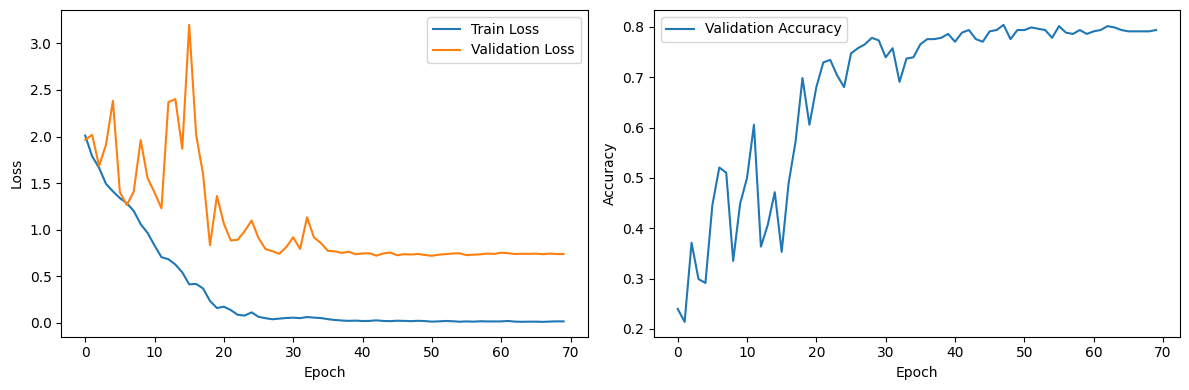

<ipython-input-6-37b190f12002>:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_emotion_model.pth'))



Classification Report:
              precision    recall  f1-score   support

     neutral       0.58      0.73      0.64        26
        calm       0.80      0.78      0.79        51
       happy       0.84      0.82      0.83        51
         sad       0.67      0.62      0.64        52
       angry       0.92      0.90      0.91        52
     fearful       0.82      0.87      0.84        52
     disgust       0.84      0.90      0.87        52
   surprised       0.80      0.69      0.74        52

    accuracy                           0.79       388
   macro avg       0.78      0.79      0.78       388
weighted avg       0.80      0.79      0.79       388



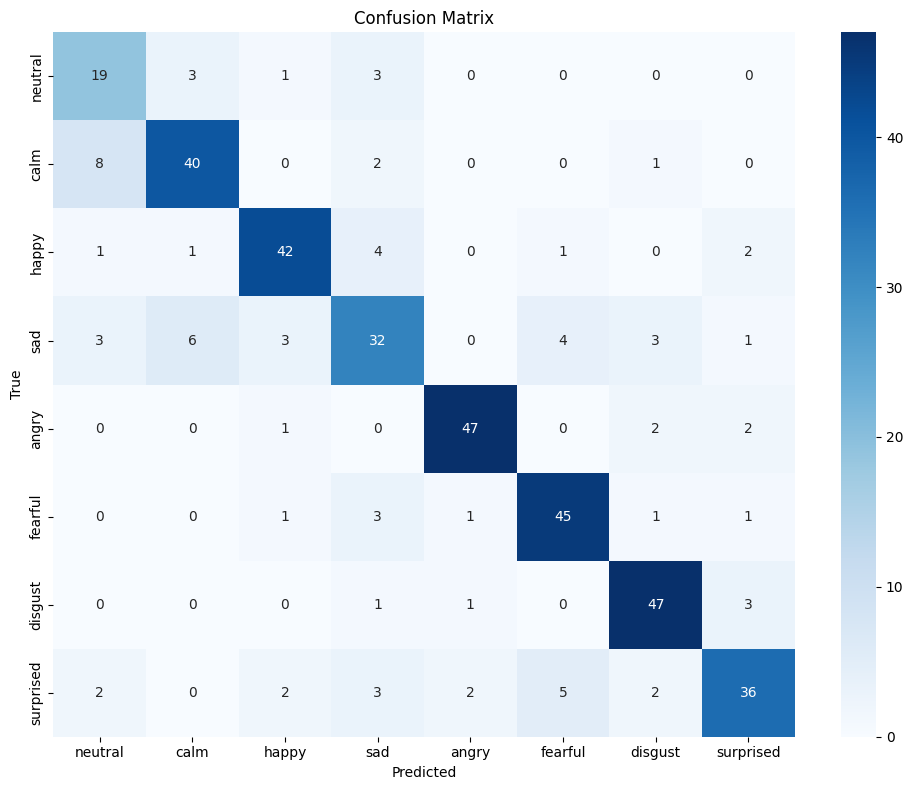

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create dataset
data_path = "/kaggle/input/speechemotionrecognition/SpeechEmotionRecognition/Train"  # Replace with your actual path
dataset = AudioDataset(data_path)

# Create stratified dataloaders with 80:20 split - THIS IS THE MAIN CHANGE
train_loader, val_loader = create_stratified_dataloaders(
    dataset, 
    batch_size=32, 
    train_split=0.66,  # Ensure 80:20 split
    seed=42
)

# Initialize model
model = EmotionCNN(num_classes=8).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training loop
num_epochs = 70
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    val_acc = correct / total
    val_accuracies.append(val_acc)
    
    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Loss: {train_loss:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_emotion_model.pth')
        print('  Saved new best model!')
    
    # Update learning rate
    scheduler.step(val_loss)

# Plotting results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on validation set
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                               target_names=["neutral", "calm", "happy", "sad", 
                                            "angry", "fearful", "disgust", "surprised"]))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"],
                yticklabels=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load('best_emotion_model.pth'))
evaluate_model(model, val_loader)